
Golden Cross events (gc=1):
        Date   Price     ma_50     ma_200
0 2014-06-23  227.90  215.5054  215.36960
1 2016-08-23  303.95  298.9022  298.81875
2 2017-12-12  433.97  401.7914  401.10275
3 2020-04-09   61.86   73.0342   72.60610
4 2020-05-28   70.23   62.9378   62.87820
5 2023-03-08   98.11   95.0914   94.94255
6 2025-07-24  200.76  185.6218  185.61945

Possible split/bonus candidates (>|50%| day move):
        Date   Price  ret_1d_pct
0 2019-06-25   52.91      -90.09
1 2020-02-01  638.13      883.86
2 2020-02-03   63.97      -89.98


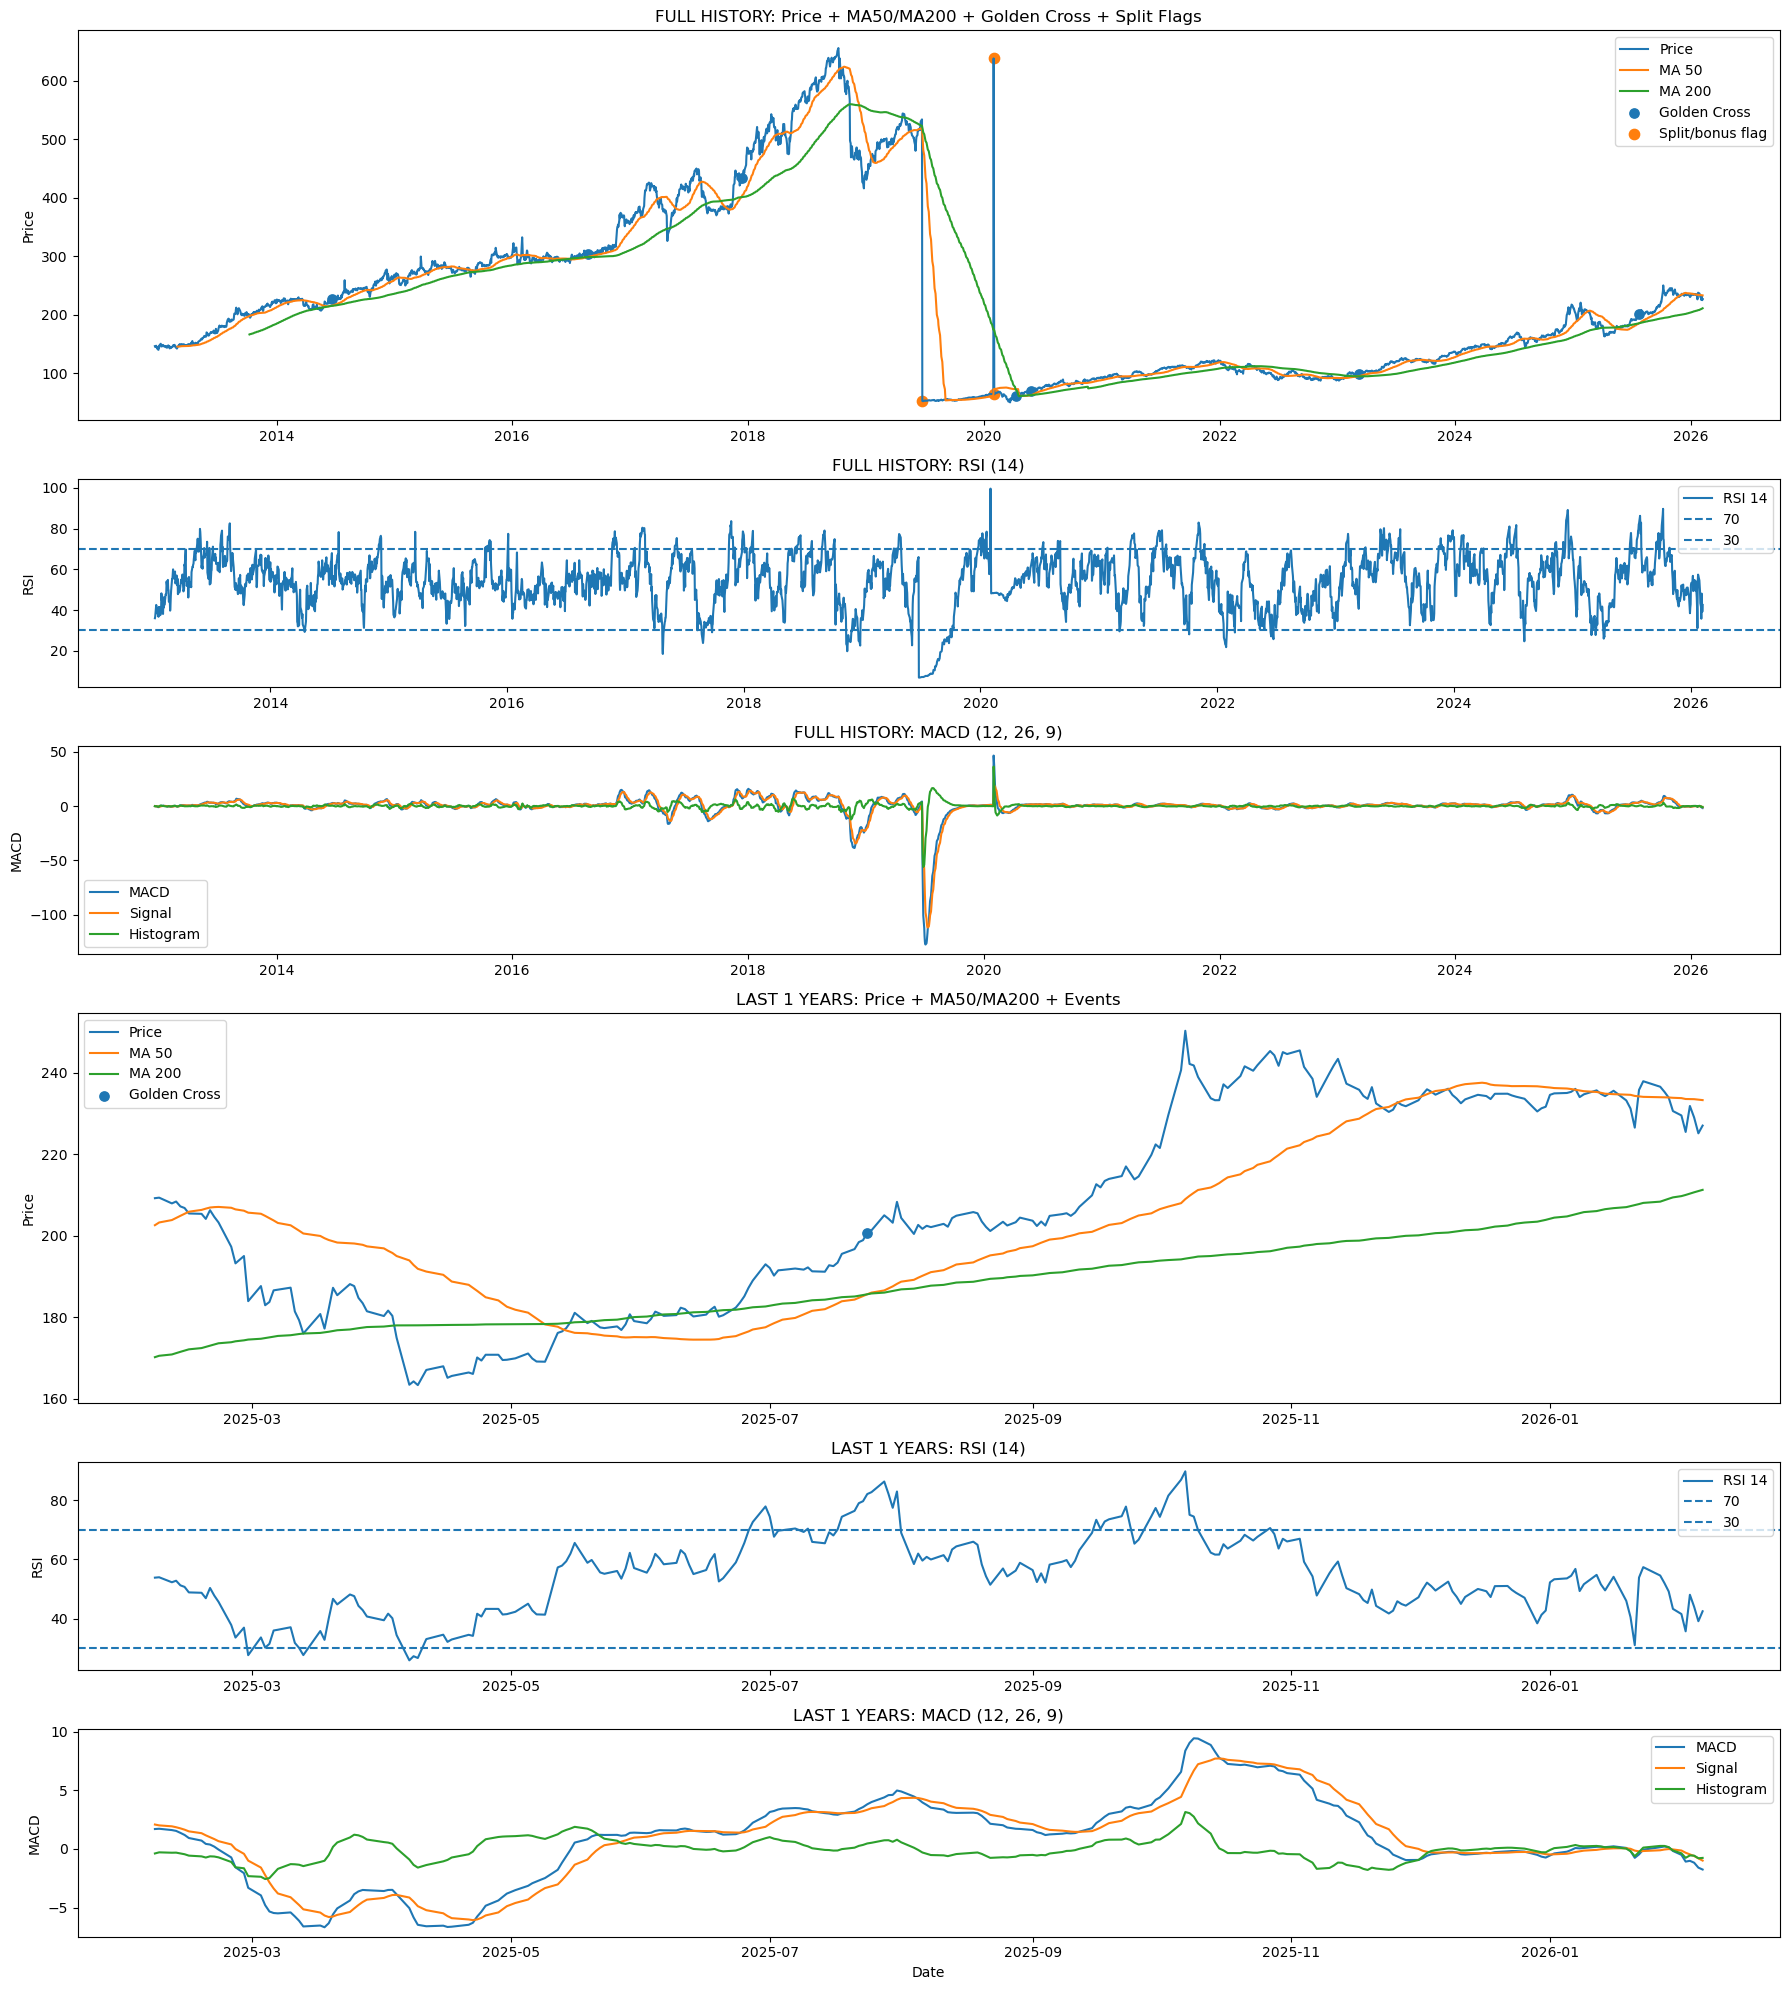

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Make notebook output wide
display(HTML("<style>.container { width: 95% !important; }</style>"))

# ========= CHANGE ONLY THIS =========
FILE = "N100 ETF Stock Price History (1).csv"
PRICE_COL = "Price"        # change to "Close" if needed
YEARS_BACK = 1             # show last N years in the bottom half of the dashboard
# ====================================

def rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# 1) Load ONCE + sort
df = pd.read_csv(FILE, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)

# 2) Indicators: MA + Golden Cross
df["ma_50"] = df[PRICE_COL].rolling(50, min_periods=50).mean()
df["ma_200"] = df[PRICE_COL].rolling(200, min_periods=200).mean()
df["gc"] = ((df["ma_50"] > df["ma_200"]) & (df["ma_50"].shift(1) <= df["ma_200"].shift(1))).astype(int)

# 3) Split/bonus flag (>|50%| daily move)
df["ret_1d"] = df[PRICE_COL].pct_change()
df["abs_ret_1d"] = df["ret_1d"].abs()
df["split_flag"] = (df["abs_ret_1d"] >= 0.50).astype(int)

# 4) MACD (12,26,9)
df["ema_12"] = df[PRICE_COL].ewm(span=12, adjust=False).mean()
df["ema_26"] = df[PRICE_COL].ewm(span=26, adjust=False).mean()
df["macd"] = df["ema_12"] - df["ema_26"]
df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()
df["macd_hist"] = df["macd"] - df["macd_signal"]

# 5) RSI (14)
df["rsi_14"] = rsi(df[PRICE_COL], period=14)

# 6) Tables
gc_table = df.loc[df["gc"] == 1, ["Date", PRICE_COL, "ma_50", "ma_200"]].reset_index(drop=True)
split_table = df.loc[df["split_flag"] == 1, ["Date", PRICE_COL, "ret_1d"]].copy()
split_table["ret_1d_pct"] = (split_table["ret_1d"] * 100).round(2)
split_table = split_table.drop(columns=["ret_1d"]).reset_index(drop=True)

print("\nGolden Cross events (gc=1):")
print(gc_table)

print("\nPossible split/bonus candidates (>|50%| day move):")
print(split_table)

# 7) Filter to last N years (for bottom half plots)
end_date = df["Date"].max()
start_date = end_date - pd.DateOffset(years=YEARS_BACK)
df_range = df.loc[df["Date"].between(start_date, end_date)].copy()

# ========= ONE FIGURE DASHBOARD (FULL + LAST N YEARS) =========
fig, axes = plt.subplots(
    6, 1,
    figsize=(18, 20),
    sharex=False,
    gridspec_kw={"height_ratios": [3, 1.6, 1.6, 3, 1.6, 1.6]}
)

def _scatter_events(ax, d, title_prefix):
    # only plot events that lie in this plotted date range
    dmin, dmax = d["Date"].min(), d["Date"].max()

    if not gc_table.empty:
        gc_in = gc_table[gc_table["Date"].between(dmin, dmax)]
        if not gc_in.empty:
            ax.scatter(gc_in["Date"], gc_in[PRICE_COL], label="Golden Cross", s=45)

    if not split_table.empty:
        sp_in = split_table[split_table["Date"].between(dmin, dmax)]
        if not sp_in.empty:
            ax.scatter(sp_in["Date"], sp_in[PRICE_COL], label="Split/bonus flag", s=55)

    ax.set_title(title_prefix)

# --- FULL HISTORY: Price + MAs + events ---
axes[0].plot(df["Date"], df[PRICE_COL], label=PRICE_COL)
axes[0].plot(df["Date"], df["ma_50"], label="MA 50")
axes[0].plot(df["Date"], df["ma_200"], label="MA 200")
_scatter_events(axes[0], df, "FULL HISTORY: Price + MA50/MA200 + Golden Cross + Split Flags")
axes[0].set_ylabel("Price")
axes[0].legend()

# --- FULL HISTORY: RSI ---
axes[1].plot(df["Date"], df["rsi_14"], label="RSI 14")
axes[1].axhline(70, linestyle="--", label="70")
axes[1].axhline(30, linestyle="--", label="30")
axes[1].set_title("FULL HISTORY: RSI (14)")
axes[1].set_ylabel("RSI")
axes[1].legend()

# --- FULL HISTORY: MACD ---
axes[2].plot(df["Date"], df["macd"], label="MACD")
axes[2].plot(df["Date"], df["macd_signal"], label="Signal")
axes[2].plot(df["Date"], df["macd_hist"], label="Histogram")
axes[2].set_title("FULL HISTORY: MACD (12, 26, 9)")
axes[2].set_ylabel("MACD")
axes[2].legend()

# --- LAST N YEARS: Price + MAs + events ---
axes[3].plot(df_range["Date"], df_range[PRICE_COL], label=PRICE_COL)
axes[3].plot(df_range["Date"], df_range["ma_50"], label="MA 50")
axes[3].plot(df_range["Date"], df_range["ma_200"], label="MA 200")
_scatter_events(axes[3], df_range, f"LAST {YEARS_BACK} YEARS: Price + MA50/MA200 + Events")
axes[3].set_ylabel("Price")
axes[3].legend()

# --- LAST N YEARS: RSI ---
axes[4].plot(df_range["Date"], df_range["rsi_14"], label="RSI 14")
axes[4].axhline(70, linestyle="--", label="70")
axes[4].axhline(30, linestyle="--", label="30")
axes[4].set_title(f"LAST {YEARS_BACK} YEARS: RSI (14)")
axes[4].set_ylabel("RSI")
axes[4].legend()

# --- LAST N YEARS: MACD ---
axes[5].plot(df_range["Date"], df_range["macd"], label="MACD")
axes[5].plot(df_range["Date"], df_range["macd_signal"], label="Signal")
axes[5].plot(df_range["Date"], df_range["macd_hist"], label="Histogram")
axes[5].set_title(f"LAST {YEARS_BACK} YEARS: MACD (12, 26, 9)")
axes[5].set_ylabel("MACD")
axes[5].set_xlabel("Date")
axes[5].legend()

plt.tight_layout()
plt.show()
